In [10]:
import os
import pickle
import joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from textwrap import wrap
import tensorflow as tf
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, Dropout, add

In [2]:
# Defining global Variables
IMAGE_PATH = 'Images'
CAPTION_PATH = 'captions.txt'

## Define Maxnim caption length based on distribution graph
MAXIMUM_CAPTION_LENGTH = 25

In [6]:
## Read captions data
data = pd.read_csv(CAPTION_PATH)
## Sample captions data 
print(f"Sample Data :- \n{data.head()}")

print(f"\nSize of the data :- {data.shape[0]}")
print(f"\nUnique Images :- {data.image.nunique()}")

Sample Data :- 
                       image   
0  1000268201_693b08cb0e.jpg  \
1  1000268201_693b08cb0e.jpg   
2  1000268201_693b08cb0e.jpg   
3  1000268201_693b08cb0e.jpg   
4  1000268201_693b08cb0e.jpg   

                                             caption  
0  A child in a pink dress is climbing up a set o...  
1              A girl going into a wooden building .  
2   A little girl climbing into a wooden playhouse .  
3  A little girl climbing the stairs to her playh...  
4  A little girl in a pink dress going into a woo...  

Size of the data :- 40455

Unique Images :- 8091


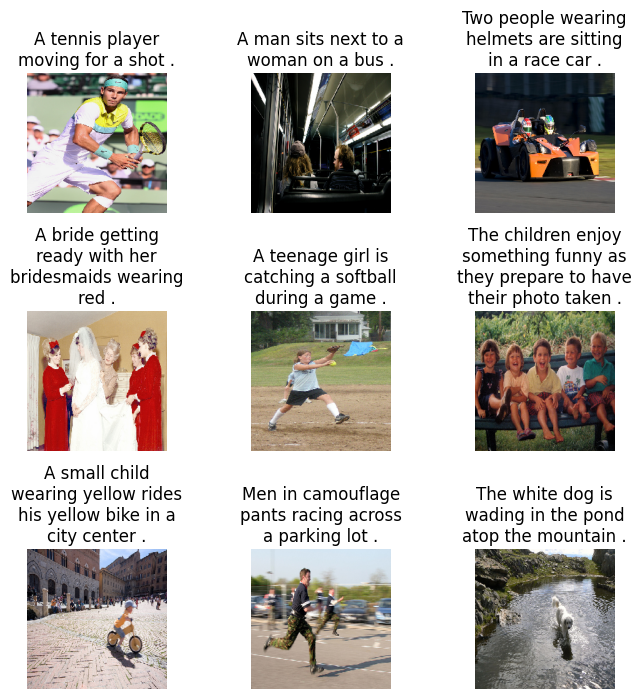

In [11]:
# To read and display Image data
def read_img(path, img_size=224):
    img = load_img(path, color_mode='rgb', target_size=(img_size, img_size))
    img = img_to_array(img)
    img = img/255
    return img 

def display_images(temp_df, num_images):
    temp_df = temp_df.reset_index(drop=True)
    plt.figure(figsize = (8,8))
    n = 0
    
    for i in range(num_images):
        n += 1
        plt.subplot(3, 3, n)
        plt.subplots_adjust(hspace=0.7, wspace=0.3)
        path = IMAGE_PATH + '/' + temp_df.image[i]
        image = read_img(path)
        plt.imshow(image)
        plt.title("\n".join(wrap(temp_df.caption[i], 20)))
        plt.axis('off')

        
## Display sample image with associated captions 
display_images(data.sample(9), 9)

In [2]:
# load vgg16 model
model = VGG16()

In [3]:
# restructure the model
model = Model(inputs=model.inputs, outputs=model.layers[-2].output)
# summarize
print(model.summary())

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [23]:
#model.save('vgg16.h5')

In [6]:
# extract features from image
features = {}
directory = 'Images'#os.path.join(BASE_DIR, 'Images')
for img_name in tqdm(os.listdir(directory)):
    # load the image from file
    img_path = directory + '/' + img_name
    image = load_img(img_path, target_size=(224, 224))
    # convert image pixels to numpy array
    image = img_to_array(image)
    # reshape data for model
    image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
    # preprocess image for vgg
    image = preprocess_input(image)
    # extract features
    feature = model.predict(image, verbose=0)
    # get image ID
    image_id = img_name.split('.')[0]
    # store feature
    features[image_id] = feature

100%|██████████████████████████████████████████████████████████████████████████████| 8091/8091 [11:24<00:00, 11.82it/s]


In [2]:
vgg_model = tf.keras.models.load_model('vgg16.h5')

In [5]:
# store features in pickle
#pickle.dump(features, open('features.pkl', 'wb'))

In [14]:
# load features from pickle
with open('features.pkl', 'rb') as f:
    features = pickle.load(f)

In [15]:
len(features['1001773457_577c3a7d70'][0])

4096

In [16]:
with open('captions.txt', 'r') as f:
    next(f)
    captions_doc = f.read()

In [17]:
# create mapping of image to captions
mapping = {}
# process lines
for line in tqdm(captions_doc.split('\n')):
    # split the line by comma(,)
    tokens = line.split(',')
    if len(line) < 2:
        continue
    image_id, caption = tokens[0], tokens[1:]
    # remove extension from image ID
    image_id = image_id.split('.')[0]
    # convert caption list to string
    caption = " ".join(caption)
    # create list if needed
    if image_id not in mapping:
        mapping[image_id] = []
    # store the caption
    mapping[image_id].append(caption)

100%|████████████████████████████████████████████████████████████████████████| 40456/40456 [00:00<00:00, 700765.51it/s]


In [18]:
len(mapping)

8091

In [19]:
def clean(mapping):
    for key, captions in mapping.items():
        for i in range(len(captions)):
        # take one caption at a time
            caption = captions[i]
            # preprocessing steps
            # convert to lowercase
            caption = caption.lower()
            # delete digits, special chars, etc., 
            caption = caption.replace('[^A-Za-z]', '')
            # delete additional spaces
            caption = caption.replace('\s+', ' ')
            # add start and end tags to the caption
            caption = 'startseq ' + " ".join([word for word in caption.split() if len(word)>1]) + ' endseq'
            captions[i] = caption

In [20]:
# before preprocess of text
mapping['1000268201_693b08cb0e']

['A child in a pink dress is climbing up a set of stairs in an entry way .',
 'A girl going into a wooden building .',
 'A little girl climbing into a wooden playhouse .',
 'A little girl climbing the stairs to her playhouse .',
 'A little girl in a pink dress going into a wooden cabin .']

In [21]:
# preprocess the text
clean(mapping)

In [22]:
# after preprocess of text
mapping['1000268201_693b08cb0e']

['startseq child in pink dress is climbing up set of stairs in an entry way endseq',
 'startseq girl going into wooden building endseq',
 'startseq little girl climbing into wooden playhouse endseq',
 'startseq little girl climbing the stairs to her playhouse endseq',
 'startseq little girl in pink dress going into wooden cabin endseq']

In [23]:
all_captions = []
for key in mapping:
    for caption in mapping[key]:
        all_captions.append(caption)

In [24]:
len(all_captions)

40455

In [25]:
all_captions[:10]

['startseq child in pink dress is climbing up set of stairs in an entry way endseq',
 'startseq girl going into wooden building endseq',
 'startseq little girl climbing into wooden playhouse endseq',
 'startseq little girl climbing the stairs to her playhouse endseq',
 'startseq little girl in pink dress going into wooden cabin endseq',
 'startseq black dog and spotted dog are fighting endseq',
 'startseq black dog and tri-colored dog playing with each other on the road endseq',
 'startseq black dog and white dog with brown spots are staring at each other in the street endseq',
 'startseq two dogs of different breeds looking at each other on the road endseq',
 'startseq two dogs on pavement moving toward each other endseq']

In [16]:
# tokenize the text
tokenizer = Tokenizer()
tokenizer.fit_on_texts(all_captions)
vocab_size = len(tokenizer.word_index) + 1

In [17]:
vocab_size

8485

In [23]:
# saving tokenizer
with open('tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [3]:
# loading tokenizer
with open('tokenizer.pickle', 'rb') as handle:
    tokenizer = pickle.load(handle)

In [26]:
# get maximum length of the caption available
max_length = max(len(caption.split()) for caption in all_captions)
max_length

35

In [18]:
image_ids = list(mapping.keys())
split = int(len(image_ids) * 0.90)
train = image_ids[:split]
test = image_ids[split:]

In [19]:
train[:5]

['1000268201_693b08cb0e',
 '1001773457_577c3a7d70',
 '1002674143_1b742ab4b8',
 '1003163366_44323f5815',
 '1007129816_e794419615']

In [20]:
epochs = 20
batch_size = 32
steps = len(train)

In [21]:
mapping['1000268201_693b08cb0e']

['startseq child in pink dress is climbing up set of stairs in an entry way endseq',
 'startseq girl going into wooden building endseq',
 'startseq little girl climbing into wooden playhouse endseq',
 'startseq little girl climbing the stairs to her playhouse endseq',
 'startseq little girl in pink dress going into wooden cabin endseq']

In [25]:
len(train)

7281

In [32]:
# create data generator to get data in batch (avoids session crash)
def data_generator(data_keys, mapping, features, tokenizer, max_length, vocab_size, batch_size):
    # loop over images
    X1, X2, y = list(), list(), list()
    n = 0
    f=True
    while f:
        f=False
        for key in data_keys:
            n += 1
            captions = mapping[key]
            # process each caption
            for caption in captions:
                # encode the sequence
                seq = tokenizer.texts_to_sequences([caption])[0]
                # split the sequence into X, y pairs
                for i in range(1, len(seq)):
                # split into input and output pairs
                    in_seq, out_seq = seq[:i], seq[i]
                    # pad input sequence
                    in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                    # encode output sequence
                    out_seq = to_categorical([out_seq],num_classes=vocab_size)[0]
                    # store the sequences
                    X1.append(features[key][0])
                    X2.append(in_seq)
                    y.append(out_seq)
            if n == batch_size:
                X1, X2, y = np.array(X1), np.array(X2), np.array(y)
                yield [X1, X2], y
                X1, X2, y = list(), list(), list()
                n = 0

In [33]:
# encoder model
# image feature layers
inputs1 = Input(shape=(4096,))
fe1 = Dropout(0.4)(inputs1)
fe2 = Dense(256, activation='relu')(fe1)
# sequence feature layers
inputs2 = Input(shape=(max_length,))
se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
se2 = Dropout(0.4)(se1)
se3 = LSTM(256)(se2)

# decoder model
decoder1 = add([fe2, se3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)

model = Model(inputs=[inputs1, inputs2], outputs=outputs)
model.compile(loss='categorical_crossentropy', optimizer='adam')

# plot the model
plot_model(model, show_shapes=True)

('You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) ', 'for plot_model/model_to_dot to work.')


In [34]:
# train the model
epochs = 20
batch_size = 32
steps = len(train) // batch_size

for i in range(epochs):
    print(i,end = " ")
    # create data generator
    generator = data_generator(train, mapping, features, tokenizer, max_length, vocab_size, batch_size)
    # fit for one epoch
    model.fit(generator, epochs=1, steps_per_epoch=steps, verbose=1)

227/227 [==============================] - 63s 278ms/step - loss: 2.1961


In [35]:
# save the model
#model.save('best_model.h5')

C:\Users\pradh\anaconda3\envs\tf_gpu\lib\site-packages\tensorflow\python\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


In [4]:
model = tf.keras.models.load_model('best_model.h5')

In [5]:
def idx_to_word(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None

In [6]:
def predict_caption(model, image, tokenizer, max_length):
    # add start tag for generation process
    in_text = 'startseq'
    # iterate over the max length of sequence
    for i in range(max_length):
        # encode input sequence
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        # pad the sequence
        sequence = pad_sequences([sequence], max_length)
        # predict next word
        yhat = model.predict([image, sequence], verbose=0)
        # get index with high probability
        yhat = np.argmax(yhat)
        # convert index to word
        word = idx_to_word(yhat, tokenizer)
        # stop if word not found
        if word is None:
            break
        # append word as input for generating next word
        in_text += " " + word
        # stop if we reach end tag
        if word == 'endseq':
            break
    return in_text

In [41]:
from nltk.translate.bleu_score import corpus_bleu
# validate with test data
actual, predicted = list(), list()

for key in tqdm(test):
    # get actual caption
    captions = mapping[key]
    # predict the caption for image
    y_pred = predict_caption(model, features[key], tokenizer, max_length)
    # split into words
    actual_captions = [caption.split() for caption in captions]
    y_pred = y_pred.split()
    # append to the list
    actual.append(actual_captions)
    predicted.append(y_pred)
    # calcuate BLEU score
    print("BLEU-1: %f" % corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0)))
    print("BLEU-2: %f" % corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0)))

  0%|                                                                                          | 0/810 [00:00<?, ?it/s]C:\Users\pradh\anaconda3\envs\tf_gpu\lib\site-packages\nltk\translate\bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
C:\Users\pradh\anaconda3\envs\tf_gpu\lib\site-packages\nltk\translate\bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
  0%|                                                                                  | 1/810 [00:02<38:38,  2.87s/it]

BLEU-1: 0.428571
BLEU-2: 0.181568


  0%|▏                                                                                 | 2/810 [00:03<19:35,  1.45s/it]

BLEU-1: 0.454545
BLEU-2: 0.213201


  0%|▎                                                                                 | 3/810 [00:04<15:02,  1.12s/it]

BLEU-1: 0.411765
BLEU-2: 0.162989


  0%|▍                                                                                 | 4/810 [00:04<13:09,  1.02it/s]

BLEU-1: 0.404255
BLEU-2: 0.137122


  1%|▌                                                                                 | 5/810 [00:05<11:33,  1.16it/s]

BLEU-1: 0.396552
BLEU-2: 0.122328


  1%|▌                                                                                 | 6/810 [00:06<10:15,  1.31it/s]

BLEU-1: 0.397059
BLEU-2: 0.113174


  1%|▋                                                                                 | 7/810 [00:06<10:24,  1.29it/s]

BLEU-1: 0.419753
BLEU-2: 0.150630


  1%|▊                                                                                 | 8/810 [00:07<08:47,  1.52it/s]

BLEU-1: 0.443182
BLEU-2: 0.182315


  1%|▉                                                                                 | 9/810 [00:07<07:58,  1.67it/s]

BLEU-1: 0.427083
BLEU-2: 0.171622


  1%|█                                                                                | 10/810 [00:08<07:55,  1.68it/s]

BLEU-1: 0.443396
BLEU-2: 0.179808


  1%|█                                                                                | 11/810 [00:08<07:18,  1.82it/s]

BLEU-1: 0.464912
BLEU-2: 0.212455


  1%|█▏                                                                               | 12/810 [00:09<08:14,  1.61it/s]

BLEU-1: 0.480315
BLEU-2: 0.223875


  2%|█▎                                                                               | 13/810 [00:10<08:44,  1.52it/s]

BLEU-1: 0.496403
BLEU-2: 0.251068


  2%|█▍                                                                               | 14/810 [00:10<08:54,  1.49it/s]

BLEU-1: 0.490066
BLEU-2: 0.239236


  2%|█▌                                                                               | 15/810 [00:11<07:53,  1.68it/s]

BLEU-1: 0.506329
BLEU-2: 0.252455


  2%|█▌                                                                               | 16/810 [00:12<08:53,  1.49it/s]

BLEU-1: 0.505814
BLEU-2: 0.254653


  2%|█▋                                                                               | 17/810 [00:12<07:47,  1.70it/s]

BLEU-1: 0.525140
BLEU-2: 0.278924


  2%|█▊                                                                               | 18/810 [00:13<07:57,  1.66it/s]

BLEU-1: 0.523553
BLEU-2: 0.285927


  2%|█▉                                                                               | 19/810 [00:13<08:08,  1.62it/s]

BLEU-1: 0.517216
BLEU-2: 0.280685


  2%|██                                                                               | 20/810 [00:14<08:03,  1.63it/s]

BLEU-1: 0.530493
BLEU-2: 0.292042


  3%|██                                                                               | 21/810 [00:15<08:55,  1.47it/s]

BLEU-1: 0.530968
BLEU-2: 0.287958


  3%|██▏                                                                              | 22/810 [00:15<07:52,  1.67it/s]

BLEU-1: 0.532184
BLEU-2: 0.288564


  3%|██▎                                                                              | 23/810 [00:16<08:04,  1.63it/s]

BLEU-1: 0.524586
BLEU-2: 0.279937


  3%|██▍                                                                              | 24/810 [00:17<08:00,  1.64it/s]Exception ignored in: <function ScopedTFGraph.__del__ at 0x000001ECFBCBAB80>
Traceback (most recent call last):
  File "C:\Users\pradh\anaconda3\envs\tf_gpu\lib\site-packages\tensorflow\python\framework\c_api_util.py", line 58, in __del__
    self.deleter(self.graph)
KeyboardInterrupt: 


BLEU-1: 0.523618
BLEU-2: 0.274150


  3%|██▌                                                                              | 25/810 [00:17<07:13,  1.81it/s]

BLEU-1: 0.530519
BLEU-2: 0.283986


  3%|██▌                                                                              | 26/810 [00:18<07:24,  1.77it/s]

BLEU-1: 0.538742
BLEU-2: 0.292903


  3%|██▋                                                                              | 27/810 [00:18<07:05,  1.84it/s]

BLEU-1: 0.532129
BLEU-2: 0.286511


  3%|██▊                                                                              | 28/810 [00:19<07:20,  1.77it/s]

BLEU-1: 0.527574
BLEU-2: 0.280336


  4%|██▉                                                                              | 29/810 [00:20<10:15,  1.27it/s]

BLEU-1: 0.523001
BLEU-2: 0.272480


  4%|███                                                                              | 30/810 [00:21<10:49,  1.20it/s]

BLEU-1: 0.521834
BLEU-2: 0.271785


  4%|███                                                                              | 31/810 [00:22<13:20,  1.03s/it]

BLEU-1: 0.510324
BLEU-2: 0.263799


  4%|███▏                                                                             | 32/810 [00:23<12:21,  1.05it/s]

BLEU-1: 0.505682
BLEU-2: 0.257625


  4%|███▎                                                                             | 33/810 [00:24<12:05,  1.07it/s]

BLEU-1: 0.506812
BLEU-2: 0.252450


  4%|███▍                                                                             | 34/810 [00:25<11:49,  1.09it/s]

BLEU-1: 0.503937
BLEU-2: 0.249895


  4%|███▌                                                                             | 35/810 [00:25<10:23,  1.24it/s]

BLEU-1: 0.507692
BLEU-2: 0.253684


  4%|███▌                                                                             | 36/810 [00:26<09:08,  1.41it/s]

BLEU-1: 0.505025
BLEU-2: 0.250558


  5%|███▋                                                                             | 37/810 [00:27<08:57,  1.44it/s]

BLEU-1: 0.506112
BLEU-2: 0.252872


  5%|███▊                                                                             | 38/810 [00:27<08:04,  1.59it/s]

BLEU-1: 0.503597
BLEU-2: 0.249903


  5%|███▉                                                                             | 39/810 [00:28<08:58,  1.43it/s]

BLEU-1: 0.512761
BLEU-2: 0.260805


  5%|████                                                                             | 40/810 [00:28<08:04,  1.59it/s]

BLEU-1: 0.519362
BLEU-2: 0.272387


  5%|████                                                                             | 41/810 [00:29<08:27,  1.52it/s]

BLEU-1: 0.516630
BLEU-2: 0.272661


  5%|████▏                                                                            | 42/810 [00:29<07:11,  1.78it/s]

BLEU-1: 0.518600
BLEU-2: 0.276094


  5%|████▏                                                                            | 42/810 [00:30<09:13,  1.39it/s]


KeyboardInterrupt: 

In [30]:
from PIL import Image
import matplotlib.pyplot as plt
def generate_caption(image_name):
    # load the image
    # image_name = "1001773457_577c3a7d70.jpg"
    image_id = image_name.split('.')[0]
    img_path = os.path.join("Images", image_name)
    image = Image.open(img_path)
    captions = mapping[image_id]
    print('---------------------Actual---------------------')
    for caption in captions:
        print(caption)
    # predict the caption
    y_pred = predict_caption(model, features[image_id], tokenizer, max_length)
    print('--------------------Predicted--------------------')
    y_pred = y_pred.split(' ')
    y_pred = ' '.join(y_pred[1:len(y_pred)-1])
    print(y_pred)
    plt.imshow(image)

---------------------Actual---------------------
startseq man prepares to enter the red building endseq
startseq man walking around the corner of red building endseq
startseq man walks past red building with fake rocket attached to it endseq
startseq man walks under building with large rocket shaped sculpture endseq
startseq person walking by red building with jet on top of it endseq
--------------------Predicted--------------------
man is standing on the side of the side of the boat


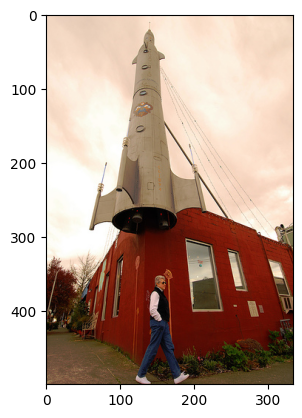

In [31]:
max_length = 35
generate_caption("436015762_8d0bae90c3.jpg")

---------------------Actual---------------------
startseq black dog and spotted dog are fighting endseq
startseq black dog and tri-colored dog playing with each other on the road endseq
startseq black dog and white dog with brown spots are staring at each other in the street endseq
startseq two dogs of different breeds looking at each other on the road endseq
startseq two dogs on pavement moving toward each other endseq
--------------------Predicted--------------------
two dogs are playing with toy


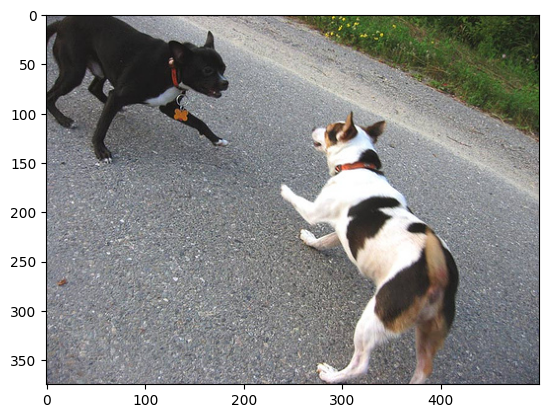

In [22]:
generate_caption("1001773457_577c3a7d70.jpg")

In [10]:
directory = 'Images'
# load the image from file
img_path = directory + '/' + '436015762_8d0bae90c3.jpg'
image = load_img(img_path, target_size=(224, 224))
# convert image pixels to numpy array
image = img_to_array(image)
# reshape data for model
image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
# preprocess image for vgg
image = preprocess_input(image)
# extract features
feature = vgg_model.predict(image, verbose=0)
# get image ID
feature

array([[0.       , 0.       , 1.5716869, ..., 1.3177805, 0.       ,
        0.       ]], dtype=float32)

In [10]:
features['436015762_8d0bae90c3']

array([[0.       , 0.       , 1.5716869, ..., 1.3177805, 0.       ,
        0.       ]], dtype=float32)

In [12]:
y_pred = predict_caption(model, feature, tokenizer, max_length=35)
y_pred

'startseq man is standing on the side of the side of the boat endseq'

In [27]:
captions = mapping['436015762_8d0bae90c3']
actual_captions = [caption.split() for caption in captions]

In [28]:
actual_captions

[['startseq',
  'man',
  'prepares',
  'to',
  'enter',
  'the',
  'red',
  'building',
  'endseq'],
 ['startseq',
  'man',
  'walking',
  'around',
  'the',
  'corner',
  'of',
  'red',
  'building',
  'endseq'],
 ['startseq',
  'man',
  'walks',
  'past',
  'red',
  'building',
  'with',
  'fake',
  'rocket',
  'attached',
  'to',
  'it',
  'endseq'],
 ['startseq',
  'man',
  'walks',
  'under',
  'building',
  'with',
  'large',
  'rocket',
  'shaped',
  'sculpture',
  'endseq'],
 ['startseq',
  'person',
  'walking',
  'by',
  'red',
  'building',
  'with',
  'jet',
  'on',
  'top',
  'of',
  'it',
  'endseq']]